<a href="https://colab.research.google.com/github/1900690/kyouyu/blob/main/Custom_Detectron2.7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectron2をカスタムオブジェクトで学習させる方法
このチュートリアルについて詳しくは[Detectron2 Library](https://ai.facebook.com/blog/-detectron2-a-pytorch-based-modular-object-detection-library-/)にあります。このノートブックでは、インスタンスセグメンテーションのための**あなた自身のカスタムデータセット**に関するトレーニングを紹介しています。

Detectron2ライブラリは、物体検出にとどまらず、セマンティックセグメンテーション、キーポイント検出、マスク、denseposeをサポートしていることは特筆すべき点である。

### 添付のブログ記事
このノートに沿って、[Detectron2のトレーニング方法](https://blog.roboflow.ai/how-to-train-detectron2/)のブログ記事を読みながら、同時進行で進めていくことをお勧めします。

### このチュートリアルで説明する手順
このチュートリアルでは、Detectron2をカスタムオブジェクトで学習させるために必要なステップを説明します。ここでは、オープンソースで無料で利用できる、[公開されている血球検出データセット](https://public.roboflow.ai/object-detection/bccd)を使用します。また、このノートブックを自分のデータで使用することも可能です。

以下のステップで検出器を学習します。

* Detectron2の依存関係をインストール
* Detectron2のカスタムオブジェクト検出データのダウンロード
* Detectron2トレーニングデータの可視化
* Detectron2トレーニングの設定を行う
* Detectron2トレーニングの実行
* Detectron2の性能評価
* テスト画像でのDetectron2推論の実行

# Detectron2の依存関係をインストール

In [1]:
# をインストールします。(colabはCUDA 10.1なのでcu101を使用)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencvはcolabにプリインストールされています。

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 21 kB/s 
     |████████████████████████████████| 6.6 MB 29.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0+cu113
    Uninstalling torchvision-0.12.0+cu113:
      Successfully uninstalled torchvision-0.12.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.5.0+cu101

In [2]:
# detectron2のインストール:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2 MB 562 kB/s 
     |████████████████████████████████| 50 kB 7.4 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=75933d4780dfe4989831b4411873d7bcfbd010e7754ca63496ac3a13d0533b08
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e48078756505c7777b75b29e
Successfully built fvcore


In [3]:
# インストールを有効にするために、この前にランタイムを再起動する必要があるかもしれません。
# いくつかの基本的なセットアップを行います。
# detectron2 ロガーのセットアップ
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# 一般的なライブラリのインポート
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# detectron2 の一般的なユーティリティをインポート
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

#デフォルトpredict


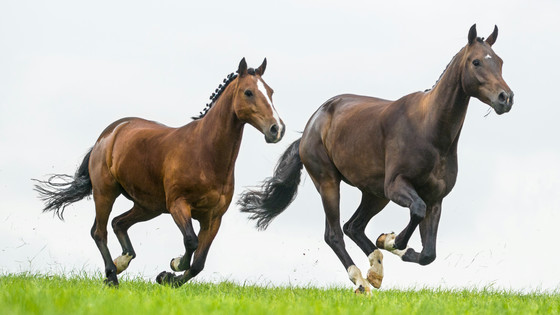

In [ ]:
#インターネット上からデータをダウンロード
!wget https://i.gzn.jp/img/2021/11/05/australia-wild-horses/00_m.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
cv2_imshow(im)

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

In [ ]:
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([17, 17], device='cuda:0')
Boxes(tensor([[ 31.5205,  55.1549, 289.7267, 288.9165],
        [238.6750,  21.7775, 519.0435, 301.4648]], device='cuda:0'))


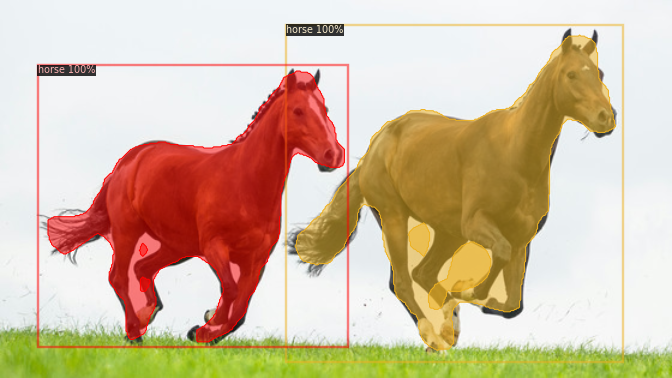

In [ ]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from matplotlib.image import imread
import scipy.misc
from PIL import Image 

num_instances = outputs["instances"].pred_masks.cpu().numpy().shape[0]
mask_array = np.moveaxis(outputs["instances"].pred_masks.cpu().numpy(), 0, -1)
#maskarray = np.moveaxis(outputs["instances"].pred_masks.cpu().numpy(), 0, -1)
mask_array_instance = []
output = np.zeros_like(im, dtype=np.uint8)
for i in range(num_instances):#iは0から
  mask_array_instance.append(mask_array[:, :, 1:(i+1)])
  output = np.where(mask_array_instance[i] == True, 255, output[:, :, 1:(i+1)])
im = Image.fromarray(output)

TypeError: ignored

In [ ]:
print(output.shape)
print(mask_array.shape)
print(mask_array_instance[0].shape)
print(im.shape)

(315, 560, 3)
(315, 560, 2)
(315, 560, 0)
(315, 560, 3)


In [ ]:
from matplotlib.image import imread
import scipy.misc
from PIL import Image  

def cropper(org_image_path, mask_array, out_file_name):
    num_instances = mask_array.shape[0]
    mask_array = np.moveaxis(mask_array, 0, -1)
    mask_array_instance = []
    img = imread(str(org_image_path))
    output = np.zeros_like(img)
    for i in range(num_instances):
        mask_array_instance.append(mask_array[:, :, i:(i+1)])
        output = np.where(mask_array_instance[i] == True, 255, output)
    im = Image.fromarray(output)
    im.save(out_file_name)

In [ ]:
#masks=outputs["instances"].pred_masks.cpu().numpy()
cropper(outputs["instances"].pred_masks.cpu().numpy(),"/content/horseout")

TypeError: ignored

# roboflowで作成したカスタムデータのインポート

* データはcoco形式にすること

In [4]:
#グーグルドライブと同期する
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#〇ドライブからcolabへコピー
!cp "/content/drive/MyDrive/バラ画像/rose-leaf_outline-instance-segmentation2.v1i.coco-segmentation.zip" "."
#解凍
!unzip -q rose-leaf_outline-instance-segmentation2.v1i.coco-segmentation.zip > /dev/null

In [6]:
#contentフォルダ内の各jsonファイルへのpassを登録
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")


WARNING [06/01 05:19:42 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/01 05:19:42 d2.data.datasets.coco]: Loaded 70 images in COCO format from /content/train/_annotations.coco.json


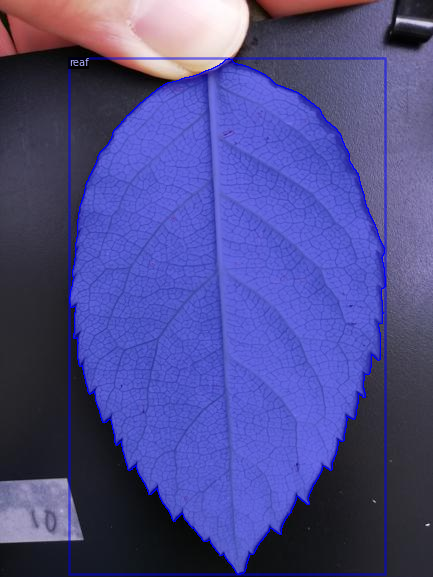

In [8]:
#トレーニングデータの可視化
#警告が出るが、これはカテゴリＩＤが1から始まっていないことによる。無視してよい
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# カスタムデータセットでDetectron2を学習

In [9]:
#ここでは、トレーニング中にCOCOの検証評価を使用するために、独自のTrainer Moduleをインポートしています。
#それ以外の場合は、検証評価は行われません。
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

* ログのetaが終了までの予測時間を示す

In [10]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# modelzooからほかのモデルを選択する場合はこちら
#: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))#InstanceSegmentationモデル
#cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))#bounding boxモデル
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  #modelzooから学習を初期化させる
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 500 #学習回数、mAPがまだ上昇している場合は上方修正、オーバーフィットの場合は下方修正。1500で一時間
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 #クラス数＋1

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/01 05:20:35 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_a3ec72.pkl: 254MB [00:48, 5.26MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to i

[06/01 05:21:28 d2.engine.train_loop]: Starting training from iteration 0
[06/01 05:21:52 d2.utils.events]:  eta: 0:09:34  iter: 19  total_loss: 2.477  loss_cls: 1.130  loss_box_reg: 0.662  loss_mask: 0.683  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  time: 1.2086  data_time: 0.0435  lr: 0.000020  max_mem: 5719M
[06/01 05:22:19 d2.utils.events]:  eta: 0:09:55  iter: 39  total_loss: 2.042  loss_cls: 0.713  loss_box_reg: 0.690  loss_mask: 0.585  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  time: 1.2752  data_time: 0.0243  lr: 0.000040  max_mem: 5719M
[06/01 05:22:46 d2.utils.events]:  eta: 0:09:30  iter: 59  total_loss: 1.564  loss_cls: 0.397  loss_box_reg: 0.710  loss_mask: 0.423  loss_rpn_cls: 0.001  loss_rpn_loc: 0.005  time: 1.2981  data_time: 0.0253  lr: 0.000060  max_mem: 5719M
[06/01 05:23:15 d2.utils.events]:  eta: 0:09:20  iter: 79  total_loss: 1.181  loss_cls: 0.221  loss_box_reg: 0.737  loss_mask: 0.227  loss_rpn_cls: 0.000  loss_rpn_loc: 0.006  time: 1.3375  data_time: 0.0252  lr:

In [27]:
!rm -rf /tmp/.tensorboard-info/

In [28]:
# テンソルボードでトレーニングカーブを見る:
%load_ext tensorboard
import tensorflow as tf
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

In [ ]:
#試験評価
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [05/02 03:24:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/02 03:24:02 d2.data.datasets.coco]: Loaded 8 images in COCO format from /content/test/_annotations.coco.json
[05/02 03:24:02 d2.data.build]: Distribution of instances among all 2 categories:
|   category   | #instances   |  category  | #instances   |
|:------------:|:-------------|:----------:|:-------------|
| leaf-outline | 0            |    reaf    | 8            |
|              |              |            |              |
|    total     | 8            |            |              |
[05/02 03:24:02 d2.data.common]: Serializing 8 elements to byte tensors and concatenating them all ...
[05/02 03:24:02 d2.data.common]: Serialized dataset takes 0.01 MiB
[05/02 03:24:02 d2.evaluation.evaluator]: Start inference on 8 images
[05/02 03:24:08 d2.evaluation.evaluator]: Total inference time: 0:00:01.004661 (0.334887 s / img per device, on 1 devices)
[05/

OrderedDict([('bbox',
              {'AP': 75.47442244224422,
               'AP-leaf-outline': nan,
               'AP-reaf': 75.47442244224422,
               'AP50': 77.84653465346535,
               'AP75': 77.84653465346535,
               'APl': 75.47442244224422,
               'APm': nan,
               'APs': nan}),
             ('segm',
              {'AP': 77.84653465346535,
               'AP-leaf-outline': nan,
               'AP-reaf': 77.84653465346535,
               'AP50': 77.84653465346535,
               'AP75': 77.84653465346535,
               'APl': 77.84653465346535,
               'APm': nan,
               'APs': nan})])

# Detectron2の学習した重みを用いた推論



In [ ]:
%ls ./output/

coco_instances_results.json                       last_checkpoint
events.out.tfevents.1651459637.efe13df6a858.71.0  metrics.json
instances_predictions.pth                         model_final.pth


In [ ]:
#my_dataset_testの中にあるデータでpredict
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.99   # このモデルのテストしきい値を設定します。
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

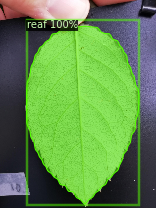

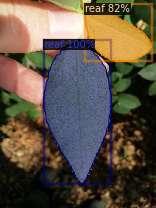

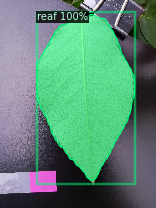

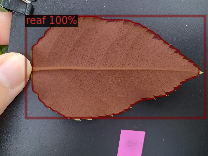

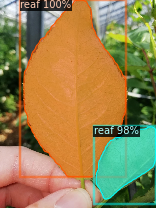

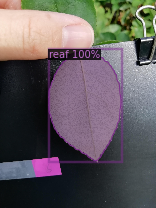

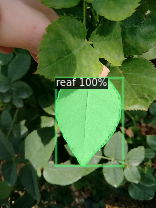

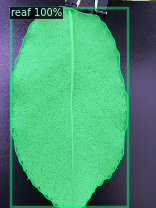

In [ ]:
#結果を可視化
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.05 #表示のサイズ
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])


In [ ]:
#画像指定ででpredict
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.99   # このモデルのテストしきい値を設定します。
predictor = DefaultPredictor(cfg)

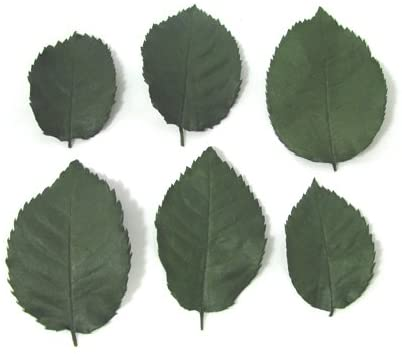

In [ ]:
#インターネット上からデータをダウンロード
!wget https://m.media-amazon.com/images/I/41tnli6VRiL._AC_.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
cv2_imshow(im)

In [ ]:
#推論
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.70
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

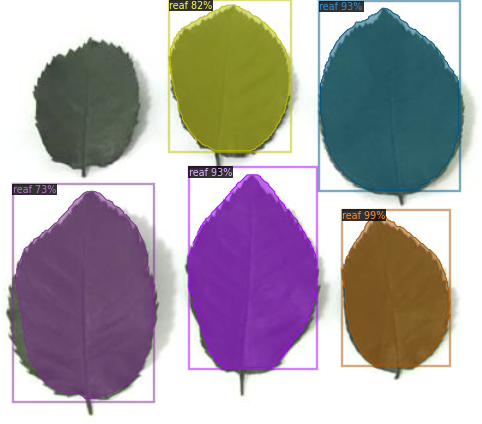

In [ ]:
#Visualizerを使用することで、画像上に予測結果を表示
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
#仕様については、 https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
#結果のクラスとbounting boxのデータとmaskデータを表示
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)
print(outputs["instances"].pred_masks)

In [ ]:
def inference(img_path):
    im = cv2.imread(img_path)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2, 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    _object = cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)
    mask = outputs['instances'].pred_masks
    _class = outputs['instances'].pred_classes
    #return(_object, mask, _class)
    return(mask)

inference("/content/images")

tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]], device='cuda:0')

In [ ]:
masks0=outputs["instances"].pred_masks.int()
numpy_masks = masks0.to('cpu').detach().numpy().copy()#tensor->numpy
print(numpy_masks)

[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
int32
